# Contract Analysis Assistant

![ClauseAI](../images/ClauseAI_logo.jpeg)

## Overview

Contract analysis requires precision and expertise across domains. Automating this process with AI agents enhances accuracy and saves time, providing actionable insights efficiently.

Our solution is a multi-agent AI system designed to streamline contract analysis and deliver customized reports.

---

## Goal

Develop an AI-powered system for contract analysis, generating insights and professional reports with minimal manual intervention.

### Key Features:

1. **Input Selection**:
   - Users upload contracts and supporting documents or integrate external legal APIs.

2. **AI Planning**:
   - A team of AI analysts is generated, each specializing in a specific domain (e.g., compliance, finance, operations).
   - `Human-in-the-loop` refines focus areas.

3. **AI Research**:
   - Analysts engage in multi-turn conversations with domain-specific AI experts.
   - Discussions cover strengths, weaknesses, risks, and improvements in the contract.

4. **Parallel Processing**:
   - Researches and data extraction run simultaneously using `map-reduce` for speed and scalability.

5. **Customizable Reports**:
   - Insights are synthesized into professional reports tailored to user needs.

---

## Workflow

1. **Input**: Upload contracts and related documents.
2. **Analysis**: AI analysts and experts extract domain-specific insights.
3. **Output**: Generate a comprehensive, actionable report.

---

## Benefits

- **Efficiency**: Parallel processing reduces time.
- **Accuracy**: Domain-specific expertise ensures precision.
- **Customization**: Flexible, tailored reports.
- **Scalability**: Process multiple contracts simultaneously.



## Environment Setup


In [35]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai docx pinecone[grpc] ipywidgets PyPDF2 python-docx



In [36]:
from langchain_community.vectorstores import Pinecone
from langchain_community.embeddings import OpenAIEmbeddings
from typing import List, Dict, Optional
from pydantic import BaseModel
import json
import os
# Import the Pinecone library
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec



In [37]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [38]:
_set_env("PINECONE_API_KEY")

## Clause Analysis Component

This section of the code defines the `ClauseRetriever` class, which forms the core of the clause analysis functionality for the agent. It retrieves and indexes contract clauses based on contract type, category, and additional metadata such as jurisdiction and version.



In [39]:
class ClauseMetadata(BaseModel):
    jurisdiction: str
    version: str
    last_updated: str


class ClauseRetriever:
    def __init__(self, json_file_path: Optional[str] = None):
        # Initialize Pinecone with GRPC client
        self.pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

        self.index_name = "contract-clauses"
        self.embeddings = OpenAIEmbeddings()

        # Get index instance
        self.index = self.pc.Index(self.index_name)

        # Initialize vector store
        self.vectorstore = Pinecone(
            index=self.index,
            embedding=self.embeddings,
            text_key="text"
        )

        # Only load and index clauses if json_file_path is provided
        if json_file_path:
            self._load_clauses(json_file_path)

    def _load_clauses(self, json_file_path: str):
        """Load and index clauses from JSON file"""
        with open(json_file_path, 'r') as file:
            self.contract_types = json.load(file)

        # Process each contract type and its clauses
        for contract_data in self.contract_types:
            self._index_contract_clauses(contract_data)

    def _index_contract_clauses(self, contract_data: Dict):
        """Index clauses for a specific contract type"""
        contract_type = contract_data["contract_type"]

        vectors_to_upsert = []
        for clause in contract_data["clauses"]:
            # Create the text to be embedded
            clause_text = f"""
            Contract Type: {contract_type}
            Clause Title: {clause['clause_title']}

            {clause['clause_text']}

            """

            # Create metadata
            metadata = {
                "contract_type": contract_type,
                "clause_title": clause["clause_title"],
                "jurisdiction": clause["metadata"]["jurisdiction"],
                "version": clause["metadata"]["version"],
                "last_updated": clause["metadata"]["last_updated"],
                "text": clause_text
            }

            # Get vector embedding
            vector = self.embeddings.embed_query(clause_text)

            # Add to upsert batch
            vectors_to_upsert.append({
                "id": f"{contract_type}-{clause['clause_title']}".lower().replace(" ", "-"),
                "values": vector,
                "metadata": metadata
            })

            # Batch upsert in chunks of 100
            if len(vectors_to_upsert) >= 100:
                self.index.upsert(vectors=vectors_to_upsert)
                vectors_to_upsert = []

        # Upsert any remaining vectors
        if vectors_to_upsert:
            self.index.upsert(vectors=vectors_to_upsert)

    def get_clauses_by_contract_type(self,
                                   contract_type: str,
                                   jurisdiction: Optional[str] = None,
                                   k: int = 5) -> List[Dict]:
        """Retrieve relevant clauses based on contract type and optional filters"""
        # Build filter dict
        filter_dict = {"contract_type": contract_type}
        if jurisdiction:
            filter_dict["jurisdiction"] = jurisdiction

        # Create query vector
        query_text = f"Find clauses for {contract_type} contract"
        query_vector = self.embeddings.embed_query(query_text)

        # Search for relevant clauses
        results = self.index.query(
            vector=query_vector,
            top_k=k,
            filter=filter_dict,
            include_values=True,
            include_metadata=True
        )

        # Format results
        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']["clause_title"],
                "clause_text": match['metadata']["text"],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })

        return formatted_results

    def search_clauses(self,
                      query: str,
                      contract_type: Optional[str] = None,
                      jurisdiction: Optional[str] = None,
                      k: int = 5) -> List[Dict]:
        """Search for clauses based on semantic similarity"""
        # Build filter dict
        filter_dict = {}
        if contract_type:
            filter_dict["contract_type"] = contract_type
        if jurisdiction:
            filter_dict["jurisdiction"] = jurisdiction

        # Create query vector
        query_vector = self.embeddings.embed_query(query)

        # Perform search
        results = self.index.query(
            vector=query_vector,
            top_k=k,
            filter=filter_dict if filter_dict else None,
            include_values=True,
            include_metadata=True
        )

        # Format results
        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']["clause_title"],
                "clause_text": match['metadata']["text"],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })

        return formatted_results

## Load clauses.json to pinecone, it should be in the data folder


In [40]:
clause_retriever = ClauseRetriever("../data/clauses.json")
employment_clauses = clause_retriever.get_clauses_by_contract_type(
        contract_type="Employment Contract",
    )

In [51]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
import operator
import os
import getpass



In [52]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [53]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Contract Review State and Supporting Models

This section defines the core data structures used for managing the state of a contract review process, detailing the contract type, review steps, modifications, and analysis.


In [54]:
class ContractInfo(BaseModel):
    contract_type: str = Field(description="Type of the contract")
    industry: Optional[str] = Field(description="Industry if identifiable")

class ReviewPlan(BaseModel):
    steps: List[str] = Field(description="Detailed steps for contract review")

class Modification(BaseModel):
    original_text: str = Field(description="Original contract text")
    suggested_text: str = Field(description="Suggested modification")
    reason: str = Field(description="Reason for modification")

class ContractReviewState(TypedDict):
    contract_text: str
    primary_objective: str
    specific_focus: Optional[str]
    contract_info: ContractInfo
    review_plan: ReviewPlan
    current_step: int
    modifications: Annotated[List[Modification], operator.add]
    clause_modifications: Annotated[List[Modification], operator.add]
    sections: Annotated[List[str], operator.add]
    clause_analysis: Annotated[List[str], operator.add]
    clauses: Annotated[List[str], operator.add]
    final_report: str

class StepAnalysis(BaseModel):
    modifications: List[Modification] = Field(default_factory=list, description="List of suggested modifications")
    analysis: str = Field(description="Analysis from this role's perspective")

## Contract Review Nodes Overview

This section outlines the key nodes in the workflow that perform tasks such as classifying contracts, retrieving clauses, generating review plans, and creating final reports. Each node plays a crucial role in the AI-driven contract analysis process.

---

### **1. Classify Contract**
This node analyzes the contract to classify:
- **Contract Type**: Identifies the type of contract (e.g., NDA, Employment Agreement, License Agreement).
- **Industry**: Determines the relevant industry based on the context, if identifiable.

This classification provides a foundation for tailoring the subsequent review and analysis steps.

---

### **2. Retrieve Clauses**
This node retrieves relevant clauses by:
- Extracting **General Clauses** that apply universally.
- Retrieving **Specific Clauses** related to the identified contract type.
- Filtering clauses for **relevancy** using semantic analysis.

The output includes formatted clauses for analysis and integration into the review workflow.

---

### **3. Execute Clause Analysis**
This node evaluates individual clauses for clarity and completeness:
- Checks if clauses are clearly represented and unambiguous.
- Identifies missing elements or unclear language.
- Suggests modifications if necessary.

This ensures that all critical clauses are accurate and appropriately integrated.

---

### **4. Create Review Plan**
Generates a detailed review plan based on the contract type and specific focus areas. Each step in the plan represents a legal role or perspective, such as:
- Employment Law Specialist.
- Compliance Officer.
- Intellectual Property Counsel.
- Financial Terms Analyst.

The review plan ensures a comprehensive and role-based approach to contract evaluation.

---

### **5. Execute Step**
Executes a specific step from the review plan, focusing on:
- Analyzing the contract from the perspective of a particular role.
- Identifying and suggesting modifications with clear justifications.
- Providing a summary of findings for that step.

This iterative process progresses through all the steps defined in the review plan.

---

### **6. Generate Final Report**
Compiles a comprehensive report summarizing:
- The contract's classification, objectives, and specific focus areas.
- Key findings from the review steps and clause analysis.
- Highlights of suggested modifications with legal justifications.
- Compliance and risk assessment insights.

The final report serves as a structured output, ready for legal review and decision-making.

---

### Purpose of Nodes
These nodes collectively form an AI-powered workflow for contract analysis, ensuring:
- Accurate classification of contracts.
- Context-aware clause retrieval and review.
- Comprehensive role-based evaluation.
- Clear and actionable outputs for legal professionals.


In [90]:
def classify_contract(state: ContractReviewState):
    """Node to classify the contract type and industry"""

    system_prompt = """Analyze the provided contract and determine:
    1. The type of contract (e.g., Employment, NDA, License Agreement)
    2. The industry it belongs to (if clear from the context)."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}")
    ]

    contract_info = llm.with_structured_output(ContractInfo).invoke(messages)
    return {"contract_info": contract_info}

def retrieve_clauses(state: ContractReviewState):
    """Node to retrieve clauses based on contract type and filter for relevancy"""
    contract_type = state['contract_info'].contract_type

    try:
        # First get ALL General Clauses (no limit)
        general_clauses = clause_retriever.get_clauses_by_contract_type(
            contract_type="General Clauses",
            k=10  # Using a high number to effectively get all clauses
        )

        # Then get specific contract clauses
        specific_clauses = clause_retriever.get_clauses_by_contract_type(
            contract_type=contract_type,
            k=10  # Get more clauses initially since we'll filter them
        )

        # Filter specific clauses for relevancy using LLM
        system_prompt = f"""You are a legal clause relevancy analyzer.
        For each clause, determine if it is relevant for a {contract_type}.
        Respond with either "RELEVANT" or "NOT RELEVANT".
        Base your decision on how essential and appropriate the clause is for this type of contract."""

        filtered_specific_clauses = []
        for clause in specific_clauses:
            messages = [
                SystemMessage(content=system_prompt),
                HumanMessage(content=f"Clause Title: {clause['clause_title']}\n\nClause Text: {clause['clause_text']}")
            ]

            response = llm.invoke(messages).content.strip().upper()
            if response == "RELEVANT":
                filtered_specific_clauses.append(clause)

        # Format clauses for inclusion in the state
        formatted_clauses = []

        # Add ALL General Clauses first
        for clause in general_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        # Then add filtered specific contract clauses
        for clause in filtered_specific_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        return {"clauses": formatted_clauses,
                 "current_step": 0}  # Return to clauses instead of sections

    except Exception as e:
        error_message = f"Error retrieving clauses: {str(e)}"
        return {"clauses": [error_message]}


def execute_step_clause(state: ContractReviewState):
    """Node to verify if each clause is clearly represented in the contract"""

    clause = state['clauses'][0]

    system_prompt = f"""You are a Legal Clause Clarity Analyst.
    Review the contract and determine if the following clause is clearly represented:

    {clause}

    Guidelines for your review:
    1. Check if the clause's key elements are present in the contract
    2. Verify if the language is clear and unambiguous
    3. Suggest modifications only if the clause is missing or unclear"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    clause_summary = f"### Clause Analysis\n{step_result.analysis}"

    return_dict = {
        "clause_analysis": [clause_summary]
    }

    if step_result.modifications:
        return_dict["clause_modifications"] = step_result.modifications

    return return_dict


def create_review_plan(state: ContractReviewState):
    """Node to create a detailed review plan based on different legal roles/perspectives"""

    system_prompt = """You are a legal contract review planner.
    Create a review plan where each step represents a different legal role/perspective for reviewing the contract.

    Context:
    - Contract Type: {contract_type}
    - Industry: {industry}
    - Primary Objective: {objective}
    - Specific Focus: {focus}

    Each step should be a specific role perspective, such as:
    - Employment Law Specialist Review
    - Intellectual Property Counsel Review
    - Compliance Officer Review
    - Financial Terms Specialist Review
    - Risk Management Review
    - Data Privacy Officer Review

    Do not include generic steps or specific clause analysis - that will happen during execution.""".format(
        contract_type=state['contract_info'].contract_type,
        industry=state['contract_info'].industry or "Not specified",
        objective=state['primary_objective'],
        focus=state['specific_focus'] or "Not specified"
    )

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}\n\nGenerate a role-based review plan.")
    ]

    review_plan = llm.with_structured_output(ReviewPlan).invoke(messages)
    return {
        "review_plan": review_plan,
        "current_step": 0
    }

def execute_step(state: ContractReviewState):
    """Node to execute each step of the review plan with specific analysis"""

    role = state['review_plan'][0]

    system_prompt = f"""You are a {role}.
    Review the contract from your professional perspective.

    Guidelines for your review:
    1. Identify specific sections that fall under your expertise
    2. Analyze those sections in detail
    3. Suggest concrete modifications where necessary

    Your response should include:
    1. analysis: A detailed explanation of your review findings
    2. modifications: A list of suggested changes, each containing:
       - original_text: The exact text to be modified
       - suggested_text: Your proposed replacement
       - reason: Clear reasoning for the change based on your role

    You may suggest multiple modifications or none if appropriate."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    section_summary = f"### {role}\n{step_result.analysis}"

    return {
        "modifications": step_result.modifications,
        "sections": [section_summary]
    }

def generate_final_report(state: ContractReviewState):
    """Node to generate the final report and summary."""
    # Extract relevant data from the state
    contract_text = state["contract_text"]
    primary_objective = state["primary_objective"]
    specific_focus = state.get("specific_focus", "Not specified")
    contract_type = state["contract_info"].contract_type
    industry = state["contract_info"].industry or "Not specified"
    review_plan = state["review_plan"]
    clause_modifications = state["clause_modifications"]
    planner_modifications = state["modifications"]
    sections = state["sections"]
    clause_analysis = state["clause_analysis"]
    clauses = state["clauses"]

    # Combine all modifications for LLM processing
    all_modifications = clause_modifications + planner_modifications

    # Prepare the system prompt
    system_prompt = (
        "You're a modifications reviewer, you get a list of modifications.\n"
        "class Modification(BaseModel):\n"
        "  original_text: str = Field(description='Original contract text')\n"
        "  suggested_text: str = Field(description='Suggested modification')\n"
        "  reason: str = Field(description='Reason for modification')\n\n"
        "Please summarize them, mostly focusing on the reason and explain it from a legal expert's point of view.\n\n"
        "The modifications:\n"
        f"{all_modifications}\n"
    )

    # Generate the messages
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="Please summarize the modifications")
    ]

    # Invoke the LLM
    try:
        review_plan = llm.invoke(messages)
        modification_summary = review_plan.content
    except Exception as e:
        modification_summary = f"Error generating summary: {str(e)}"

    # Generate the report
    report = "\n".join([
        "===============================================",
        "                  Contract Review Report       ",
        "===============================================",
        "",
        "Contract Overview",
        "-----------------",
        f"Primary Objective: {primary_objective}",
        f"Specific Focus: {specific_focus}",
        "",
        f"Contract Type: {contract_type}",
        f"Industry: {industry}",
        "",
        "Sections and Clauses Analyzed:",
        "------------------------------",
        f"Total Sections Reviewed: {len(sections)}",
        f"Total Clauses Analyzed: {len(clauses)}",
        "",
        "Key Findings and Analysis:",
        "--------------------------",
        "\n".join(f"- {analysis}" for analysis in clause_analysis),
        "",
        "Highlights of Suggested Modifications:",
        "--------------------------------------",
        modification_summary,
        "",
        "Compliance and Risk Assessment:",
        "-------------------------------",
        "- The contract has been reviewed for compliance with relevant laws and regulations.",
        "- Potential risks and mitigation strategies have been identified.",
        "- Tailored suggestions have been provided to enhance the contract’s effectiveness.",
        "",
        "Final Notes:",
        "------------",
        "Please ensure all suggested modifications are incorporated and reviewed by a legal expert before finalizing the contract.",
        "",
        "===============================================",
        "                  End of Report               ",
        "===============================================",
    ])

    return {"final_report": report}



## Parallel work

#### check the clauses and the steps of the plan in parallel using map-reduce



In [99]:
from langgraph.constants import Send


def continue_to_clauses_check_execute(state: ContractReviewState):
    return [Send("execute_step_clause", {"contract_text": state["contract_text"], "clauses": c}) for c in state["clauses"]]


def continue_to_plan_check_execute(state: ContractReviewState):
    return [Send("execute_step", {"contract_text": state["contract_text"], "review_plan": step}) for step in state["review_plan"].steps]



## The graph

In [100]:
# Create the graph
builder = StateGraph(ContractReviewState)

# Add nodes
builder.add_node("classify_contract", classify_contract)
builder.add_node("retrieve_clauses", retrieve_clauses)
builder.add_node("execute_step_clause", execute_step_clause)
builder.add_node("create_review_plan", create_review_plan)
builder.add_node("execute_step", execute_step)
builder.add_node("generate_final_report", generate_final_report)

# Add edges
builder.add_edge(START, "classify_contract")
builder.add_edge("classify_contract", "retrieve_clauses")

builder.add_conditional_edges("retrieve_clauses", continue_to_clauses_check_execute, ["execute_step_clause"])
builder.add_edge("execute_step_clause", "create_review_plan")

builder.add_conditional_edges("create_review_plan", continue_to_plan_check_execute, ["execute_step"])
builder.add_edge("execute_step", "generate_final_report")

builder.add_edge("generate_final_report", END)

# Compile the graph

# Create the checkpointer
checkpointer = MemorySaver()

# Create memory store
in_memory_store = InMemoryStore()

# Compile graph with both checkpointer and store
graph = builder.compile(
    checkpointer=checkpointer,
    store=in_memory_store
)

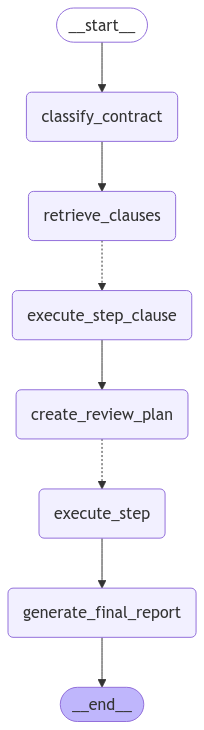

In [101]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## An Example Usage

### upload a contract file and describe your Primary Objective and Specific Focus (optional)

In [102]:
import ipywidgets as widgets
from IPython.display import display
import PyPDF2
import docx

# Function to extract text from a PDF
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to extract text from a DOCX file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
    return text

# Variables to store file content and user inputs
uploaded_file_path = None
contract = ""
primary_objective = ""
specific_focus = ""

# Callback function to handle file upload
def handle_file_upload(change):
    global uploaded_file_path
    uploaded_file = change['new']
    for file_name, file_info in uploaded_file.items():
        uploaded_file_path = file_name
        with open(file_name, 'wb') as f:
            f.write(file_info['content'])
        print(f"File {file_name} uploaded successfully!")

# File upload widget
upload_widget = widgets.FileUpload(accept='.pdf,.docx', multiple=False)
upload_widget.observe(handle_file_upload, names='value')

# Text inputs for primary_objective and specific_focus
primary_objective_input = widgets.Text(
    description="Primary Objective:",
    placeholder="Enter the primary objective",
)

specific_focus_input = widgets.Text(
    description="Specific Focus:",
    placeholder="Enter the specific focus",
)

# Button to save inputs and extract file content
def save_inputs_and_extract_file_content(_):
    global contract, primary_objective, specific_focus

    # Check if a file has been uploaded
    if not uploaded_file_path:
        print("Please upload a file before saving inputs!")
        return

    # Determine file type and extract text
    if uploaded_file_path.endswith('.pdf'):
        contract = extract_text_from_pdf(uploaded_file_path)
    elif uploaded_file_path.endswith('.docx'):
        contract = extract_text_from_docx(uploaded_file_path)
    else:
        print("Unsupported file format. Please upload a PDF or DOCX file.")
        return

    # Save user inputs
    primary_objective = primary_objective_input.value
    specific_focus = specific_focus_input.value

    # Display the results
    print("\n--- Results ---")
    print(f"Extracted Contract Text (first 500 chars):\n{contract[:500]}...")  # Showing a snippet for clarity
    print(f"Primary Objective: {primary_objective}")
    print(f"Specific Focus: {specific_focus}")

save_button = widgets.Button(description="Save & Extract")
save_button.on_click(save_inputs_and_extract_file_content)

# Display widgets
display(upload_widget)
display(primary_objective_input)
display(specific_focus_input)
display(save_button)


FileUpload(value={}, accept='.pdf,.docx', description='Upload')

Text(value='', description='Primary Objective:', placeholder='Enter the primary objective')

Text(value='', description='Specific Focus:', placeholder='Enter the specific focus')

Button(description='Save & Extract', style=ButtonStyle())

File MICROSOFT EMPLOYMENT AGREEMENT.docx uploaded successfully!

--- Results ---
Extracted Contract Text (first 500 chars):
MICROSOFT EMPLOYMENT AGREEMENT
This Employment Agreement (“Agreement”) is made and entered into as of [Start Date], by and between Microsoft Corporation, a corporation organized under the laws of the State of Washington, with its principal office at One Microsoft Way, Redmond, WA 98052-6399 (“Employer”), and Tom Cohen, residing at [Employee Address] (“Employee”).

1. Position and Duties
1.1 Position: Employee is hereby employed as a [Job Title, e.g., Software Engineer], reporting to [Supervisor’...
Primary Objective: Negotiate better terms and ensure compliance
Specific Focus: 


In [103]:
# Example usage
input_state = {
    "contract_text": contract,
    "primary_objective": primary_objective,
    "specific_focus": specific_focus,
}
# Update the config structure
config = {
    "thread_id": "1",  # String instead of nested dict
    "user_id": "user_123"
}

result = graph.invoke(input_state, config)
print(result['final_report'])

                  Contract Review Report       

Contract Overview
-----------------
Primary Objective: Negotiate better terms and ensure compliance
Specific Focus: 

Contract Type: Employment Agreement
Industry: Technology

Sections and Clauses Analyzed:
------------------------------
Total Sections Reviewed: 8
Total Clauses Analyzed: 8

Key Findings and Analysis:
--------------------------
- ### Clause Analysis
The clause in question is the "Non-Compete and Non-Solicitation" clause, which is clearly represented in the contract. The key elements of this clause are present, including the duration of the non-compete and non-solicitation obligations (one year following termination), the scope of the non-compete (not engaging in or providing services to a competing business in the same capacity), and the geographical scope (within the United States or any other region where Microsoft operates). The language used is clear and unambiguous, specifying the obligations of the employee during a

## Download modified contract (optional)

### You can run this cell to download the contract with the suggested modifications.

In [104]:
from docx import Document
from docx.shared import RGBColor
from docx.oxml import OxmlElement

def apply_modifications_to_contract(contract_text, all_modifications, output_path="Modified_Contract.docx"):
    """
    Applies modifications to the given contract text and outputs a modified DOCX file.

    Parameters:
    - contract_text (str): The original contract text.
    - all_modifications (list): List of modifications, where each modification is a dictionary with:
        - "original_text" (str): The text to be replaced.
        - "suggested_text" (str): The suggested replacement text.
        - "reason" (str): The reason for the modification.
    - output_path (str): The output file path for the modified contract (default: "Modified_Contract.docx").
    """
    # Create a new document
    doc = Document()

    # Split the contract text into paragraphs
    paragraphs = contract_text.split("\n")

    def add_strikethrough(run):
          r = run._element
          rPr = r.get_or_add_rPr()
          strike = OxmlElement("w:strike")
          rPr.append(strike)

    # Process each paragraph
    for paragraph_text in paragraphs:
        # Check if the paragraph contains any modifications
        modified = False
        for mod in all_modifications:
            if mod.original_text in paragraph_text:
                modified = True

                # Create a new paragraph with the modifications
                p = doc.add_paragraph()

                # Add original text with strikethrough
                original_run = p.add_run(mod.original_text)
                add_strikethrough(original_run)

                # Add suggested text in red
                suggested_run = p.add_run("\n" + mod.suggested_text)
                suggested_run.font.color.rgb = RGBColor(255, 0, 0)  # Red

                # Add reason in gray
                reason_run = p.add_run("\n(" + mod.reason + ")")
                reason_run.font.color.rgb = RGBColor(128, 128, 128)  # Gray

                break

        # If no modifications, add the paragraph as-is
        if not modified:
            doc.add_paragraph(paragraph_text)

    # Save the modified document
    doc.save(output_path)
    print(f"Modified contract saved to {output_path}")



contract_text = result["contract_text"]
clause_modifications = result["clause_modifications"]
planner_modifications = result["modifications"]

all_modifications = clause_modifications + planner_modifications

apply_modifications_to_contract(contract_text, all_modifications, "Modified_Contract.docx")


Modified contract saved to Modified_Contract.docx
